In [1]:
#Title: Energy forecasting using LSTM Networks
#Author: Arslan Ahmed (arslan.m.ahmed@gmail.com)
#Date: 2nd March, 2018

#import all packages that we may need

import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.cross_validation import KFold # use for cross validation
from sklearn import preprocessing # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import ExtraTreesClassifier
from scipy import signal

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout
from pandas import concat
import matplotlib.dates as md

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#function to convert time series data to apply supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [3]:
#read energy data

df_e = pd.read_csv('UKdata_energy.csv', parse_dates={'time_e' : ['Time']}, infer_datetime_format=True, na_values=['nan','?'], index_col='time_e')

In [4]:
#read weather data

df_w = pd.read_csv('UKdata_weather.csv', parse_dates={'time_w' : ['time']}, infer_datetime_format=True, na_values=['nan','?'], index_col='time_w')

In [5]:
#select data from 1st Jan 2013 to 28th Feb 2014
df_e=df_e['2012-12-01':'2014-02-28']
df_w=df_w['2012-12-01':'2014-02-28']

In [6]:
df_w=df_w.resample('30min').mean()
df_e=df_e.resample('30min').mean()

In [7]:
print(df_w.shape)
print(df_e.shape)

(21359, 8)
(21313, 3)


In [8]:
df = pd.concat([df_e, df_w], axis=1, join='inner')

In [9]:
df=df.interpolate(method='linear')

In [10]:
# df['Day of week'] = df.index.weekday.astype(int)
# df["Weekend"] = (df["Day of week"] > 5).astype(int)
df.iloc[:,0:3] *= 1000

In [11]:
#display first five rows
df.head()

,D0009,D0664,D0935,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity
2012-12-11 00:00:00,227.0,160.0,108.0,11.440,216.0,5.16,3.460,1019.980,3.72,1.850,0.890
2012-12-11 00:30:00,219.0,115.0,144.0,11.160,214.5,5.27,3.565,1019.990,3.98,1.725,0.890
2012-12-11 01:00:00,164.0,98.0,118.0,10.880,213.0,5.38,3.670,1020.000,4.24,1.600,0.890
2012-12-11 01:30:00,144.0,160.0,109.0,11.385,213.0,5.32,3.675,1020.015,4.01,1.745,0.895
2012-12-11 02:00:00,147.0,99.0,138.0,11.890,213.0,5.26,3.680,1020.030,3.78,1.890,0.900


In [12]:
no_of_features=len(df.columns)

In [13]:
#describe the data to see mean, std, percentiles etc..
df.describe()

,D0009,D0664,D0935,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity
count,21313.000000,21313.000000,21313.000000,21313.000000,21313.000000,21313.000000,21313.000000,21313.000000,21313.000000,21313.000000,21313.000000
mean,217.410430,280.198212,176.468705,11.234644,191.358373,10.122775,6.107658,1012.680811,8.680887,3.990434,0.777662
std,256.299452,229.750894,156.364030,3.031993,90.645215,6.108630,5.332310,11.564630,7.374703,2.049326,0.139664
min,17.000000,38.000000,44.000000,0.270000,0.000000,-3.860000,-8.920000,975.740000,-8.880000,0.040000,0.230000
25%,109.000000,110.000000,81.000000,10.150000,111.000000,5.664862,2.170000,1005.320000,2.950000,2.490000,0.700000
50%,151.000000,215.000000,143.000000,12.160000,213.000000,9.220000,6.020000,1013.630000,7.325000,3.785000,0.810000
75%,216.000000,372.000000,205.000000,13.100000,251.000000,14.350000,10.040000,1020.875000,14.350000,5.180000,0.885922
max,4481.000000,2425.000000,1589.000000,16.090000,359.000000,32.400000,18.950000,1040.130000,32.420000,14.800000,1.000000


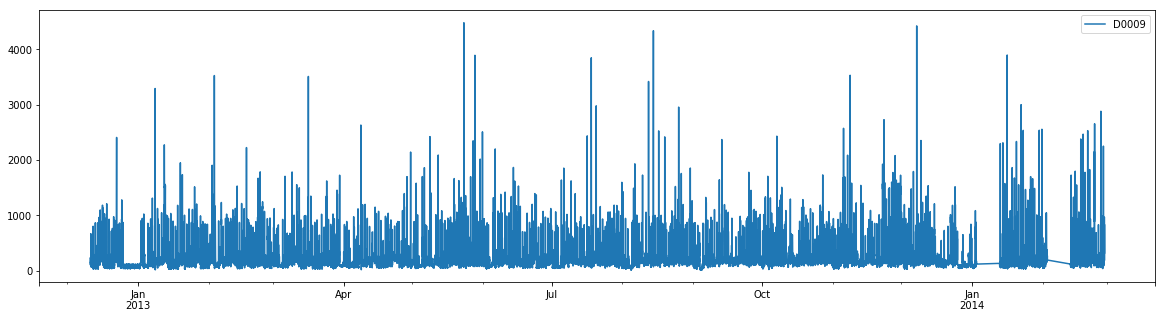

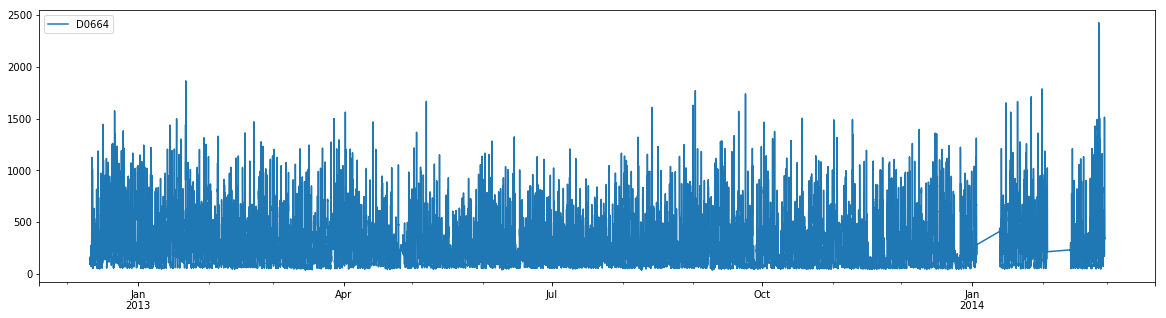

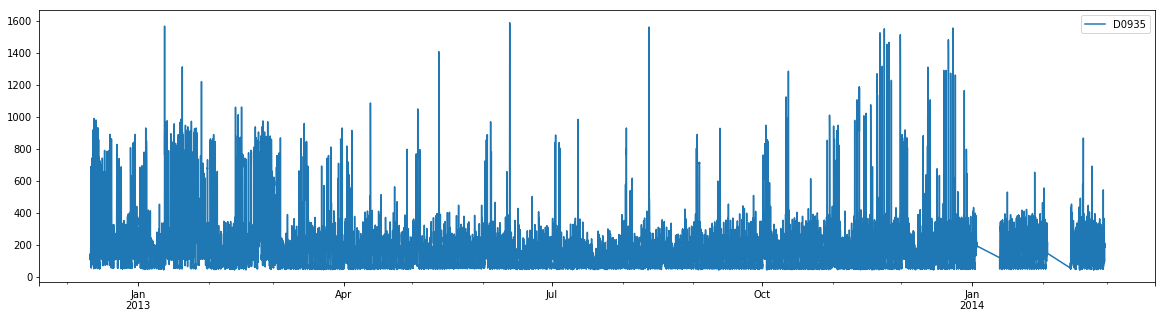

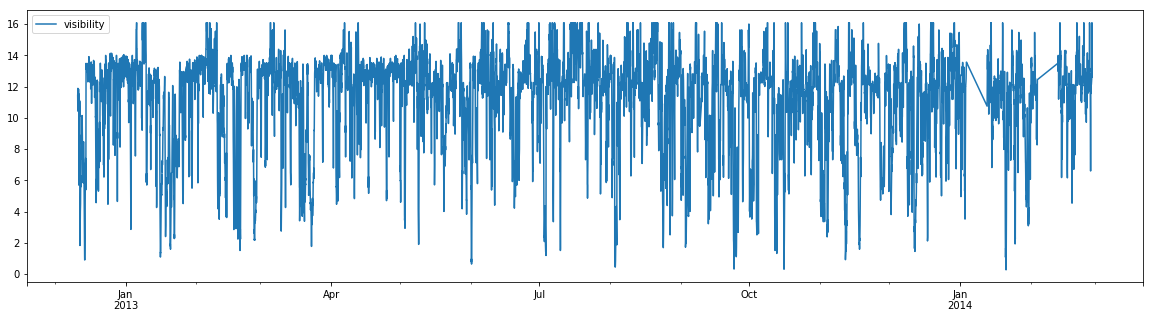

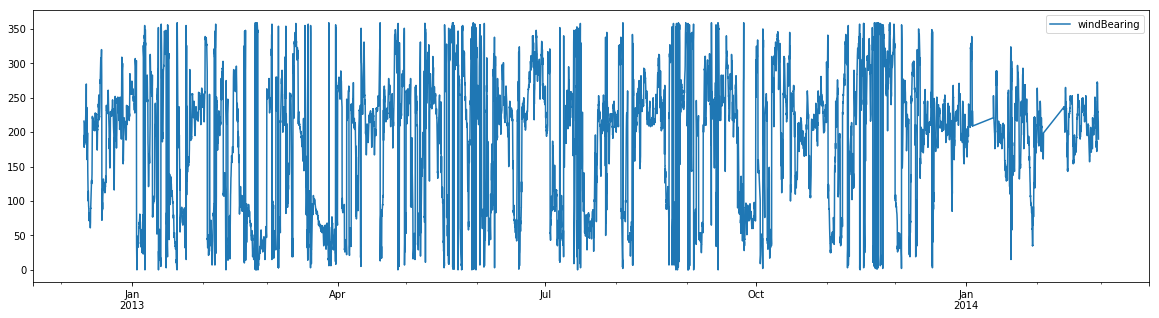

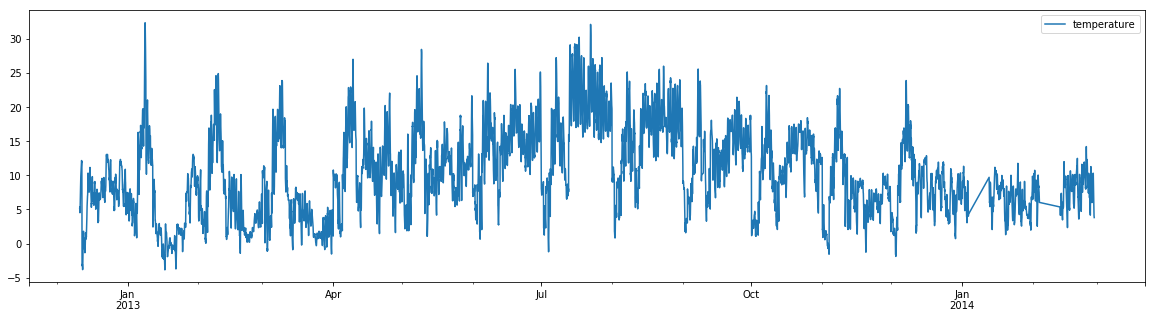

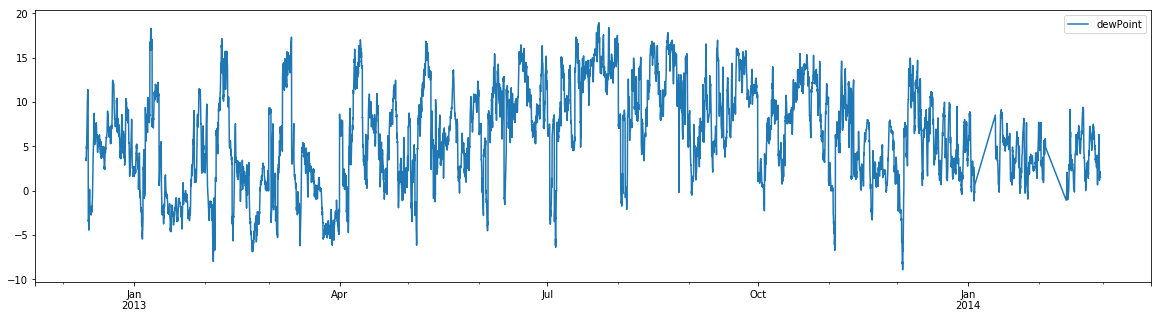

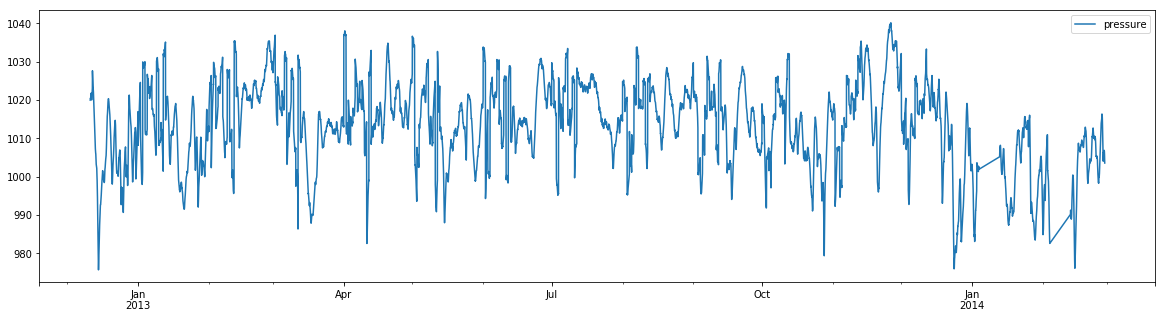

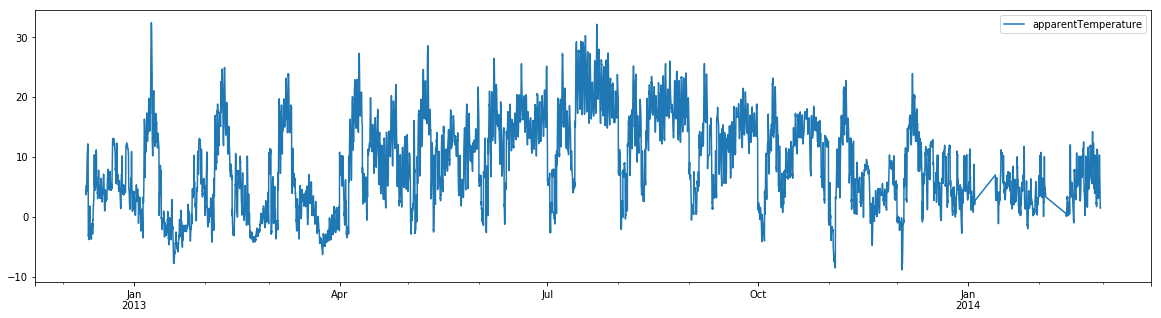

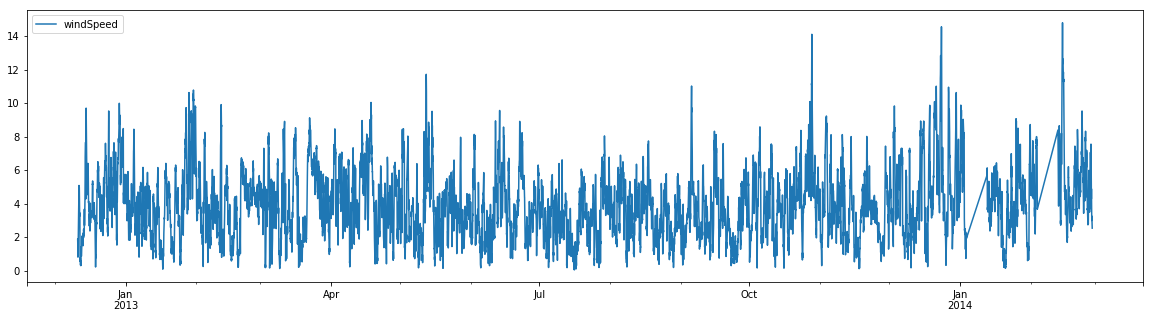

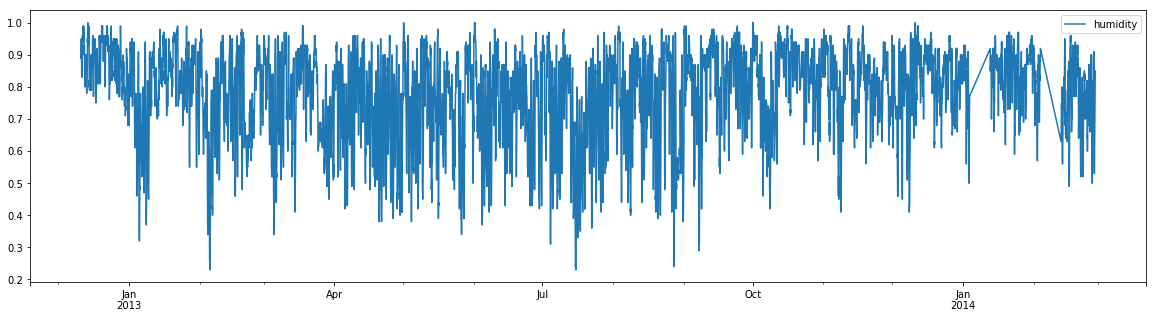

In [14]:
#plotting all columns with respect to time for original data
for j in range(0,no_of_features):        
        plt.figure(figsize=(20,5))
        df.iloc[:,j].plot(legend=True)

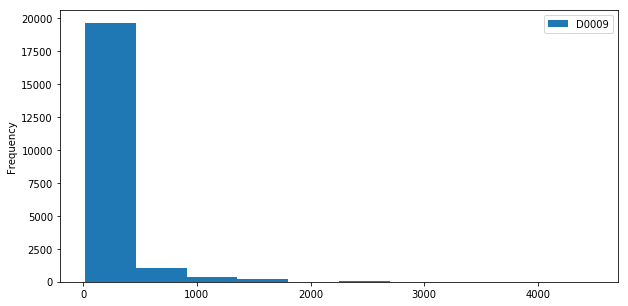

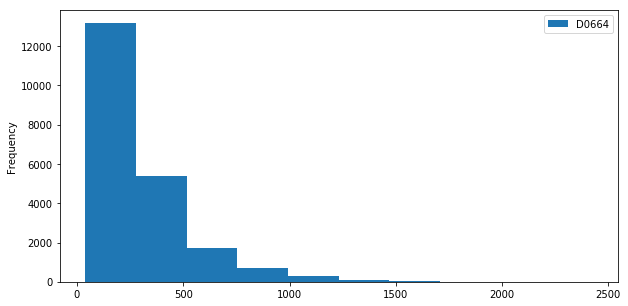

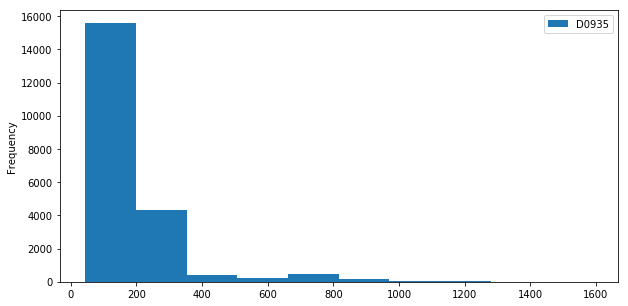

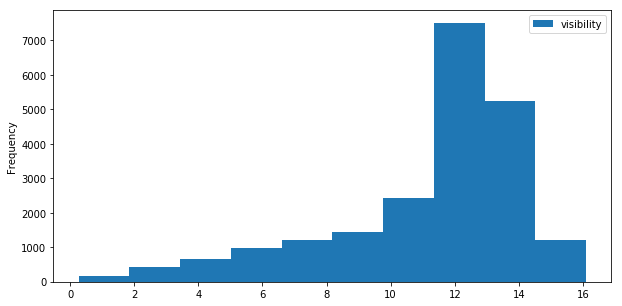

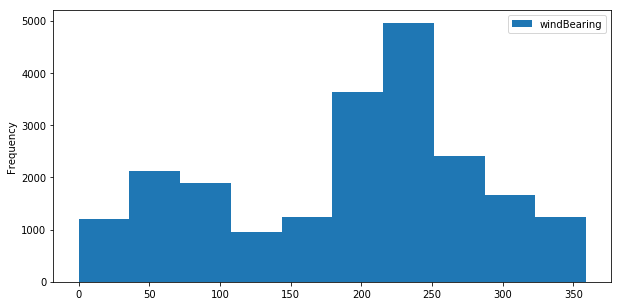

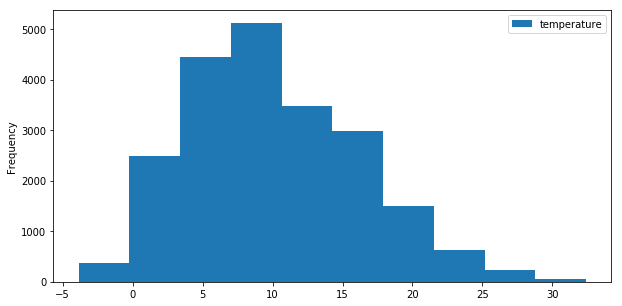

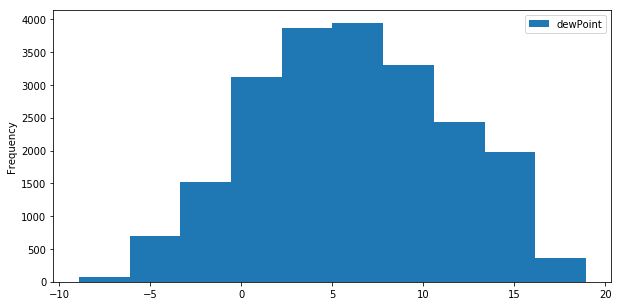

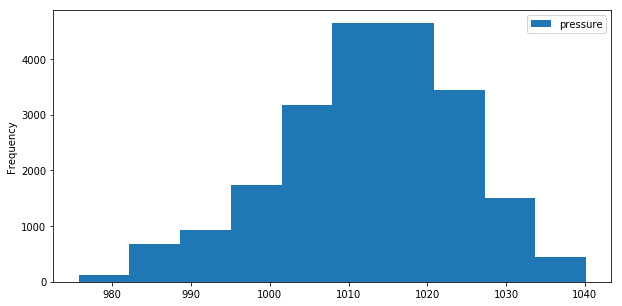

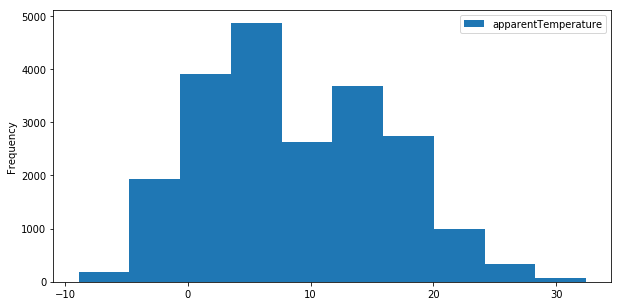

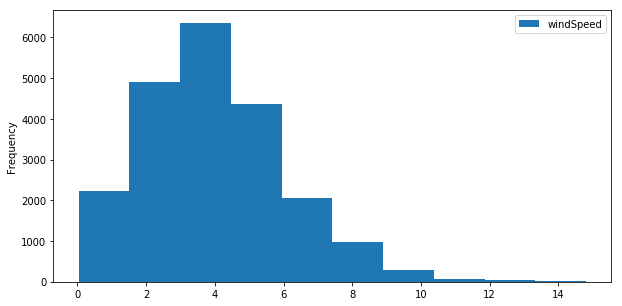

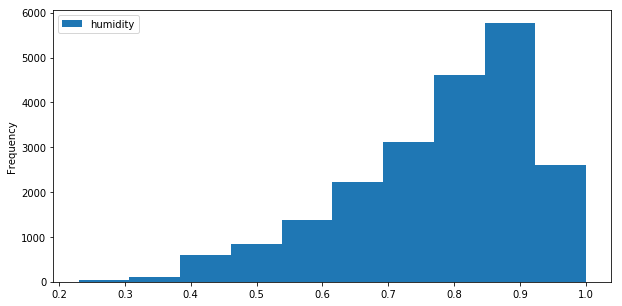

In [15]:
#histograom of original data

for j in range(0,no_of_features):        
        plt.figure(figsize=(10,5))
        df[df.columns[j]].plot.hist(legend=True)    

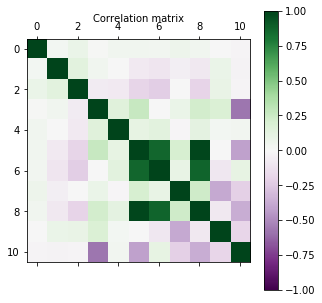

In [16]:
# Correlations matrix of original data
plt.figure(figsize=(5,5))
plt.matshow(df.corr(method='pearson'),vmax=1,vmin=-1,cmap='PRGn', fignum=1)
plt.title('Correlation matrix', size=10)
plt.colorbar()
plt.show()

In [17]:
#removing outliers
df[df.D0009 > df.D0009.quantile(.9)]=np.nan #data above 90 percentile will be filled with NaN
df[df.D0664 > df.D0664.quantile(.9)]=np.nan
df[df.D0935 > df.D0935.quantile(.9)]=np.nan
df=df.fillna(method='pad')

In [18]:
# another sanity check to make sure that there are no nan
df.isnull().sum()

D0009                  0
D0664                  0
D0935                  0
visibility             0
windBearing            0
temperature            0
dewPoint               0
pressure               0
apparentTemperature    0
windSpeed              0
humidity               0
dtype: int64

In [19]:
df.describe()

,D0009,D0664,D0935,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity
count,21313.000000,21313.000000,21313.000000,21313.000000,21313.000000,21313.000000,21313.000000,21313.000000,21313.000000,21313.000000,21313.000000
mean,152.447966,228.896683,139.075001,11.210505,191.874279,10.128640,6.095162,1012.671461,8.696992,3.998173,0.776854
std,65.286983,142.177391,63.353184,3.032358,90.651177,6.125034,5.340794,11.549203,7.383615,2.051441,0.140247
min,17.000000,38.000000,44.000000,0.310000,0.000000,-3.860000,-8.795000,976.000000,-8.880000,0.040000,0.230000
25%,106.000000,104.000000,82.000000,10.090000,113.000000,5.666406,2.150000,1005.320000,2.980000,2.500000,0.700000
50%,144.000000,198.000000,137.000000,12.130000,213.000000,9.270000,6.010000,1013.600000,7.470000,3.805000,0.809078
75%,189.808732,331.000000,185.000000,13.100000,252.000000,14.340000,10.015000,1020.820000,14.340000,5.190000,0.885000
max,347.000000,571.000000,281.000000,16.090000,359.000000,32.400000,18.950000,1040.130000,32.420000,14.800000,1.000000


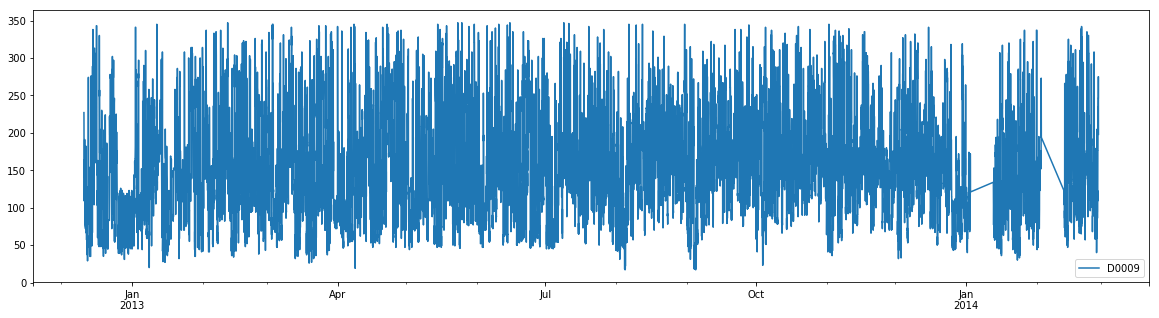

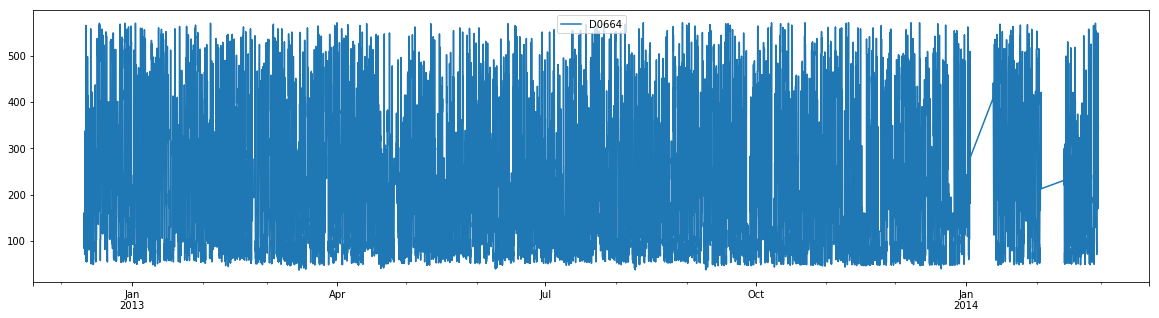

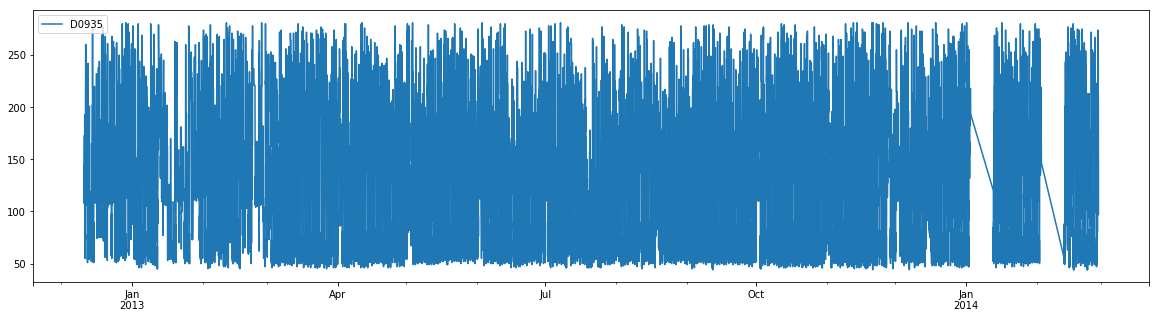

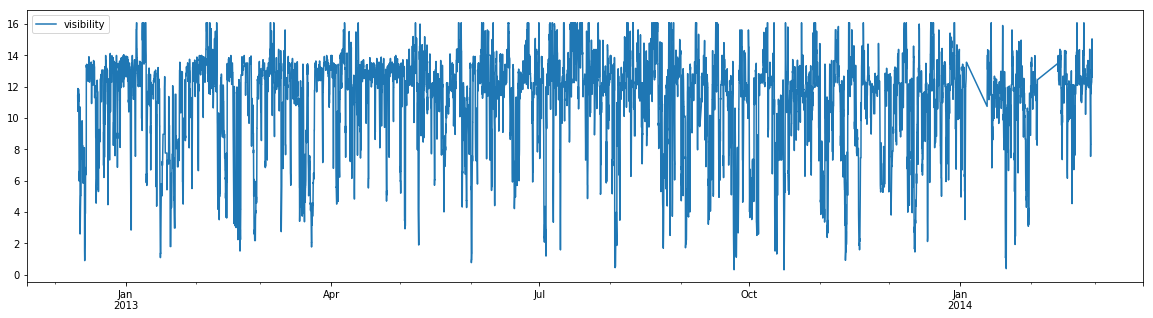

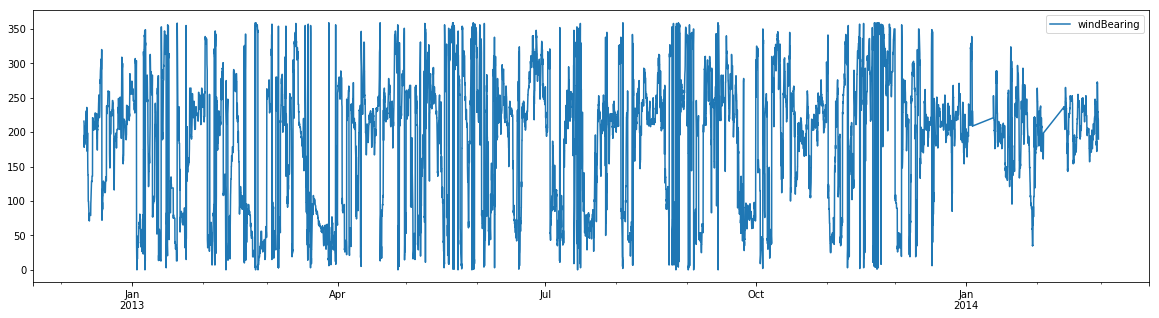

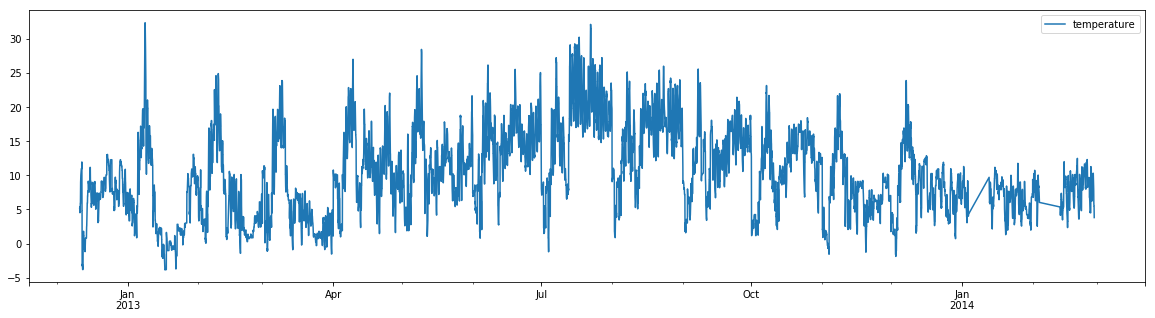

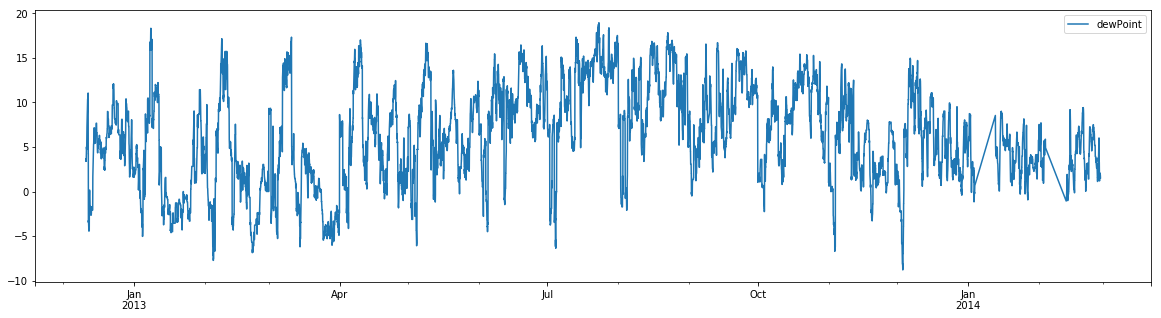

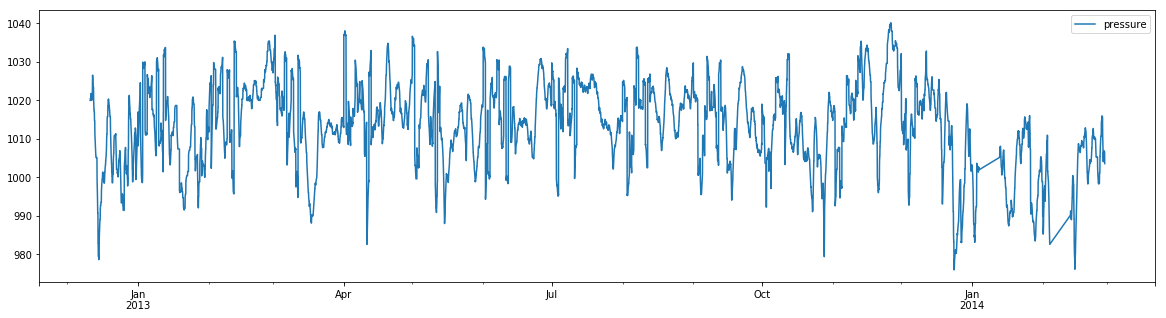

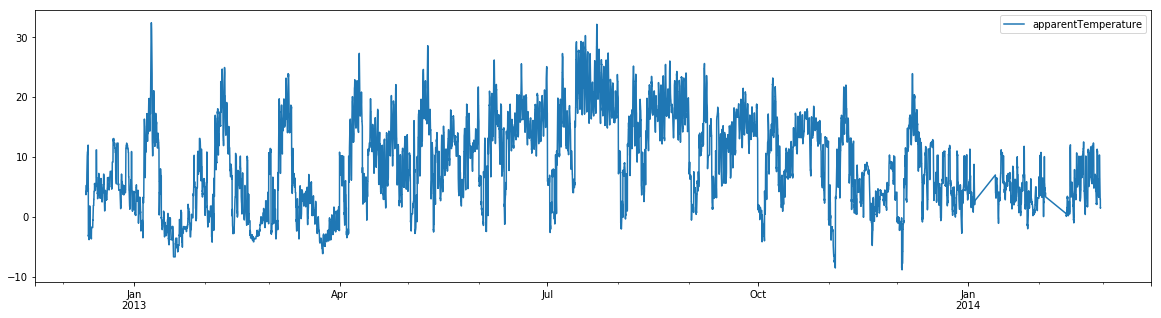

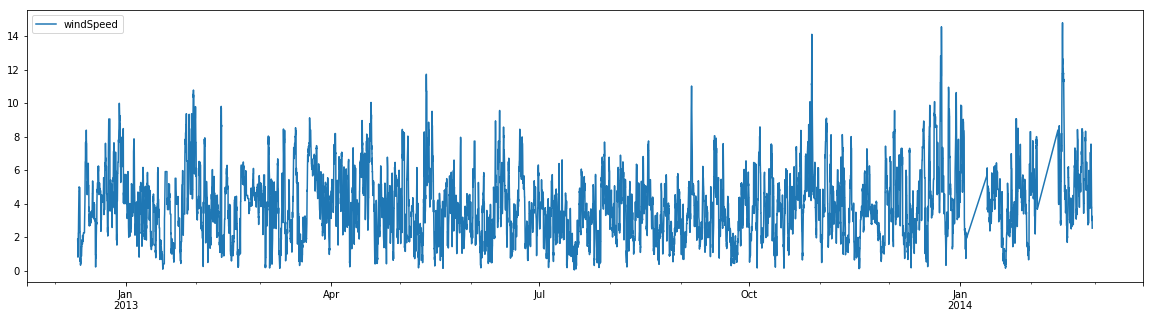

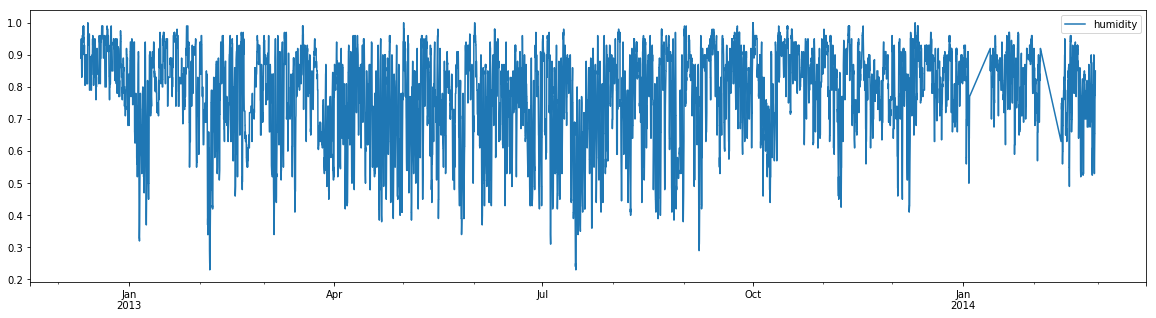

In [20]:
#plotting all columns with respect to time after removing outliers and missing values
for j in range(0,no_of_features):        
        plt.figure(figsize=(20,5))
        df.iloc[:,j].plot(legend=True)

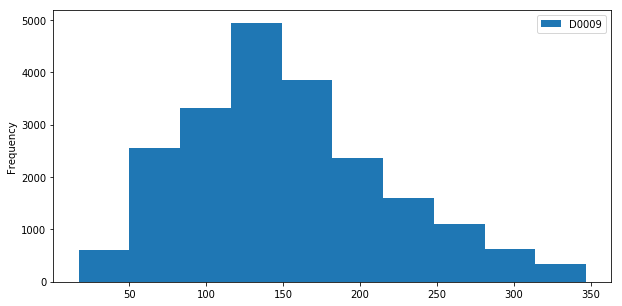

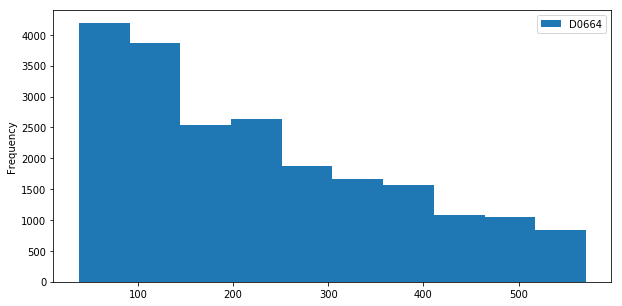

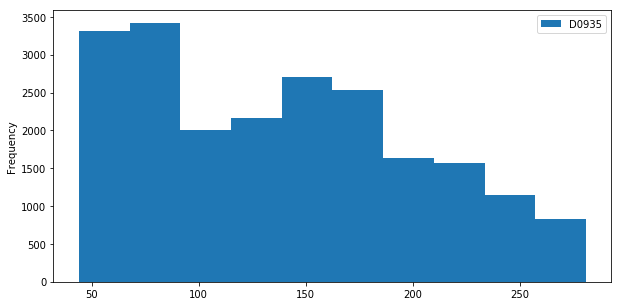

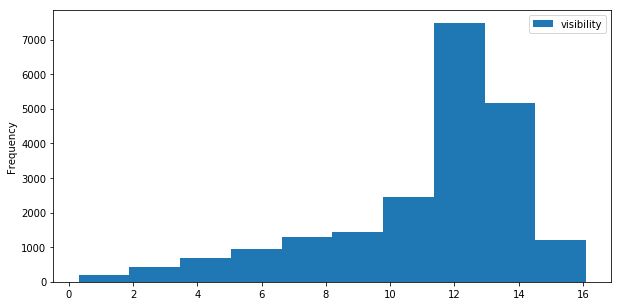

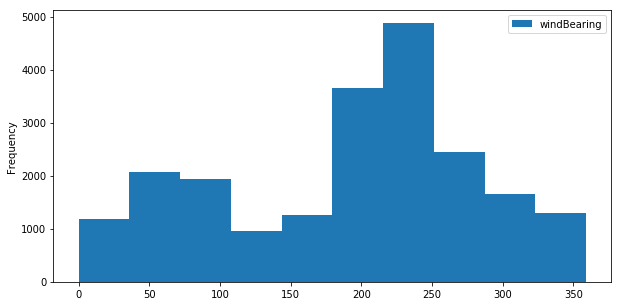

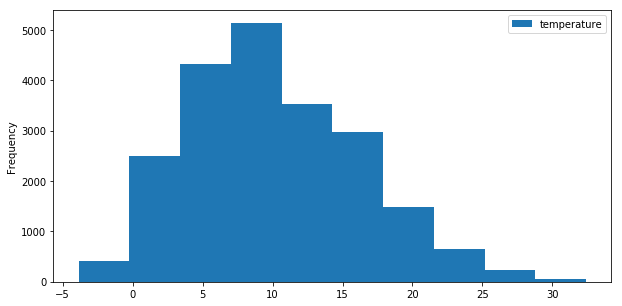

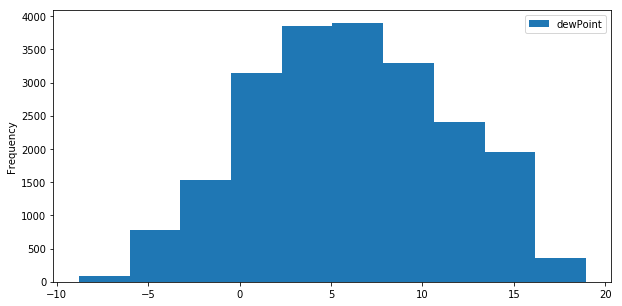

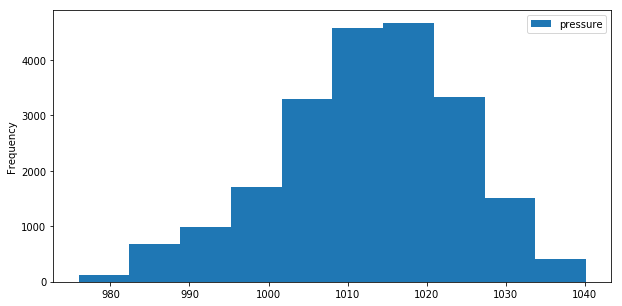

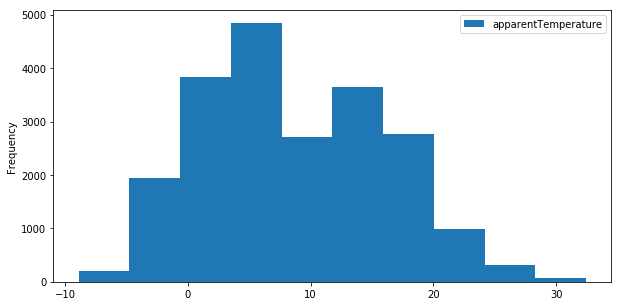

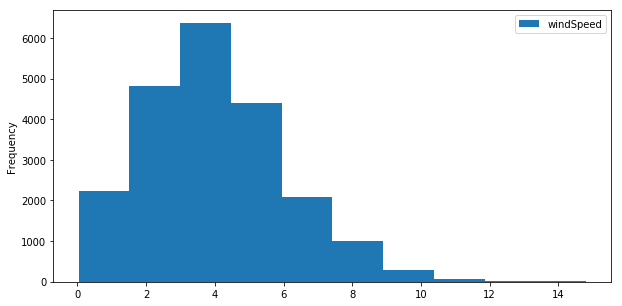

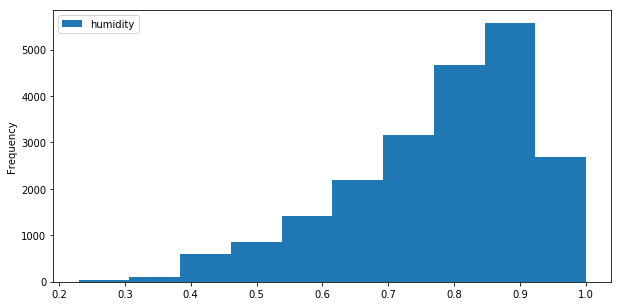

In [21]:
#histogram for data after removing outliers and missing values
for j in range(0,no_of_features):        
        plt.figure(figsize=(10,5))
        df[df.columns[j]].plot.hist(legend=True)    

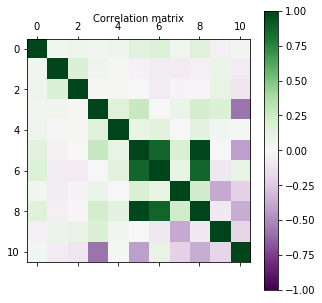

In [22]:
# Correlations matrix of data with removed outliers and missing values
plt.figure(figsize=(5,5))
plt.matshow(df.corr(method='pearson'),vmax=1,vmin=-1,cmap='PRGn', fignum=1)
plt.title('Correlation matrix', size=10)
plt.colorbar()
plt.show()

In [23]:
model_tree = ExtraTreesClassifier()
alpha=df.iloc[:,1:]
beta=df.iloc[:,0].astype(int)

In [24]:
model_tree.fit(alpha, beta)
print(model_tree.feature_importances_)

[0.10416636 0.10280684 0.09793652 0.09926128 0.09603386 0.10062416
 0.10535585 0.09851054 0.10173247 0.09357212]


In [25]:
#drop features that are correlated with each other
df=df.drop(df.columns[[0,6,8]], axis=1)
#df=df.drop(df.columns[1:], axis=1)

In [26]:
#revised no. of features after dropping correlated features
no_of_features=len(df.columns)

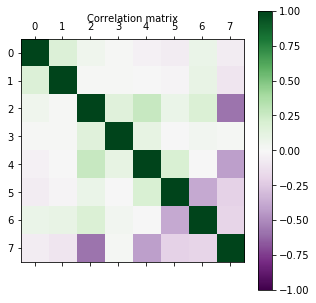

In [27]:
# Correlations matrix of data after dropping correlated features
plt.figure(figsize=(5,5))
plt.matshow(df.corr(method='pearson'),vmax=1,vmin=-1,cmap='PRGn', fignum=1)
plt.title('Correlation matrix', size=10)
plt.colorbar()
plt.show()

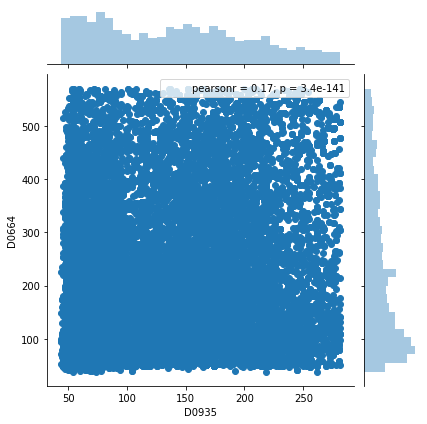

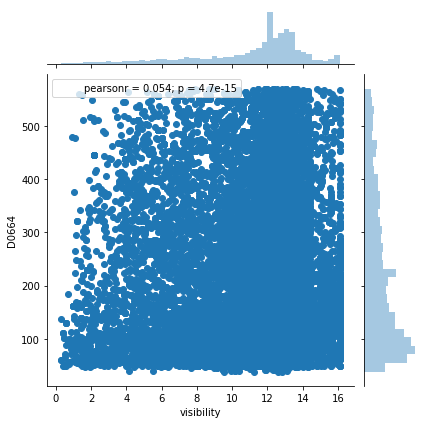

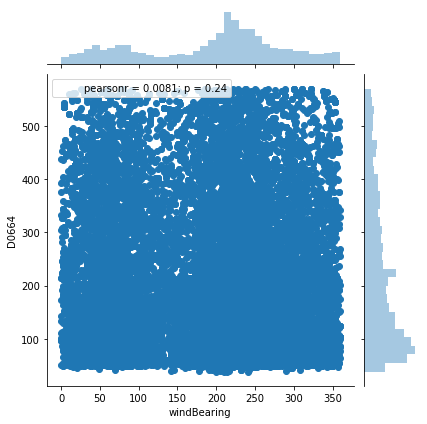

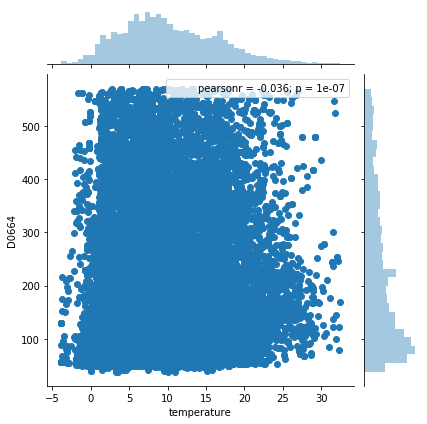

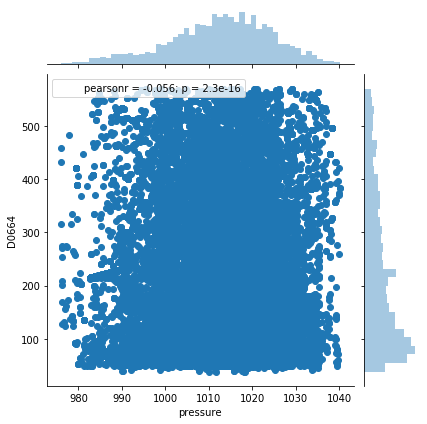

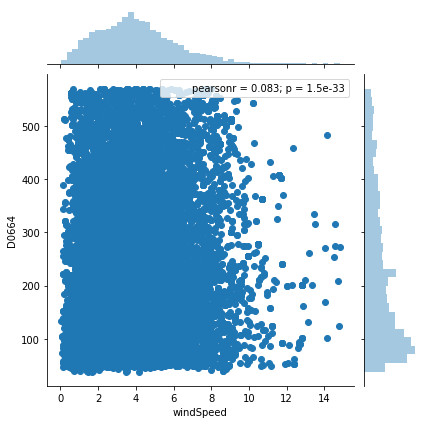

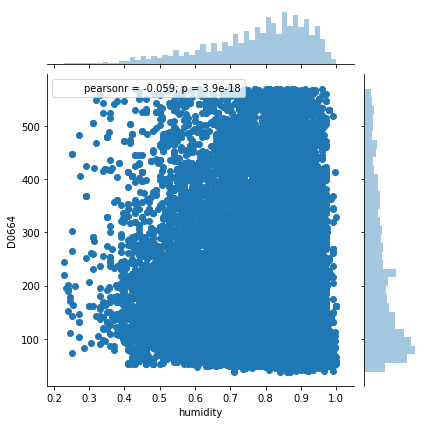

In [28]:
#corelation of all the features (on x-axis) with the target variable Energy (on y-axis) - after removing outliers and missing values
for j in range(1,no_of_features):
    sns.jointplot(x=df.columns[j],y=df.columns[0],data=df)

In [29]:
#data scaling from 0 to 1 of original data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df)

In [30]:
no_of_timesteps=1
reframed = series_to_supervised(scaled, no_of_timesteps, 1)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.228893   0.270042   0.705323   0.601671   0.248759   0.685794   
2   0.144465   0.421941   0.687579   0.597493   0.251793   0.685950   
3   0.112570   0.312236   0.669835   0.593315   0.254826   0.686106   
4   0.228893   0.274262   0.701838   0.593315   0.253172   0.686340   
5   0.114447   0.396624   0.733840   0.593315   0.251517   0.686574   

   var7(t-1)  var8(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   var5(t)  \
1   0.122629   0.857143  0.144465  0.421941  0.687579  0.597493  0.251793   
2   0.114160   0.857143  0.112570  0.312236  0.669835  0.593315  0.254826   
3   0.105691   0.857143  0.228893  0.274262  0.701838  0.593315  0.253172   
4   0.115515   0.863636  0.114447  0.396624  0.733840  0.593315  0.251517   
5   0.125339   0.870130  0.091932  0.341772  0.687579  0.544568  0.241313   

    var6(t)   var7(t)   var8(t)  
1  0.685950  0.114160  0.857143  
2  0.686106  0.105691  0.857143  
3  0.686

In [31]:
# drop columns we don't want to predict
col_array=np.arange(0,len(reframed.columns))
reframed=reframed.loc[:,(col_array<no_of_features*no_of_timesteps+1) | (col_array%(no_of_features)==0)]

In [32]:
print(reframed.head())
print(reframed.shape)

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.228893   0.270042   0.705323   0.601671   0.248759   0.685794   
2   0.144465   0.421941   0.687579   0.597493   0.251793   0.685950   
3   0.112570   0.312236   0.669835   0.593315   0.254826   0.686106   
4   0.228893   0.274262   0.701838   0.593315   0.253172   0.686340   
5   0.114447   0.396624   0.733840   0.593315   0.251517   0.686574   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.122629   0.857143  0.144465  
2   0.114160   0.857143  0.112570  
3   0.105691   0.857143  0.228893  
4   0.115515   0.863636  0.114447  
5   0.125339   0.870130  0.091932  
(21312, 9)


In [55]:
n_train_time = 2*24*365; # hours used for training.....
original_n_train_time=n_train_time;
pred_list=[]; #predicted values that will replace the original test_y values
testing_rows=2*24*4;#hours to predict
#testing_rows=reframed.shape[0]-original_n_train_time-1
test1 = reframed.values[n_train_time:n_train_time+testing_rows, :] #original testing data, this will later be modified with the predicted data generated by for loop
test_y1 = test1[:, -1] #see comment in above line
batch_size_fit=1

In [56]:
train = reframed.values[:n_train_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], no_of_timesteps, no_of_features))
print(train_X.shape)

(17520, 1, 8)


In [57]:
#LSTM model
model = Sequential()
# model.add(LSTM(20, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(Dropout(0.2))
# model.add(Dense(1))
# model.add(LSTM(20,return_sequences=True))
# model.add(Dropout(0.2))
# model.add(Dense(1))
# model.add(LSTM(20,return_sequences=True))
# model.add(Dropout(0.2))
# model.add(Dense(1))
# model.add(LSTM(10,return_sequences=True))
# model.add(Dropout(0.2))
# model.add(Dense(1))

# model.add(LSTM(20))



model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
# adam = keras.optimizers.Adamax(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=10, batch_size=batch_size_fit, verbose=2, shuffle=True)

Epoch 1/10
 - 23s - loss: 0.0272
Epoch 2/10
 - 22s - loss: 0.0244
Epoch 3/10
 - 22s - loss: 0.0241
Epoch 4/10
 - 22s - loss: 0.0239
Epoch 5/10
 - 23s - loss: 0.0238
Epoch 6/10
 - 23s - loss: 0.0237
Epoch 7/10
 - 23s - loss: 0.0238
Epoch 8/10
 - 23s - loss: 0.0238
Epoch 9/10
 - 31s - loss: 0.0237
Epoch 10/10
 - 32s - loss: 0.0237


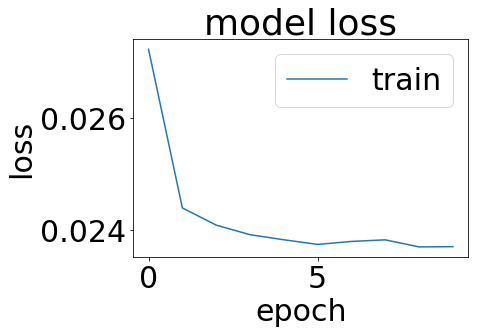

In [58]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [59]:

for j in range(0,testing_rows):
    print('Loop # ',j)
    test = reframed.values[n_train_time:n_train_time+1, :]
    test_X = test[:, :-1]
    test_X = test_X.reshape((test_X.shape[0], no_of_timesteps, no_of_features))
    yhat = model.predict(test_X,batch_size=batch_size_fit)
    for k in range(0,len(reframed.columns),no_of_features):
        if((k+no_of_features)<(len(reframed.columns)-1)):
            reframed.values[n_train_time+1,k]=reframed.values[n_train_time,(k+no_of_features)];
    reframed.values[n_train_time+1,(len(reframed.columns)-1-no_of_features)]=yhat;
#     reframed.values[n_train_time+1,0]=yhat;
    n_train_time=n_train_time+1
    pred_list=np.append(pred_list,yhat)
    print(reframed[n_train_time-1:n_train_time])
    print(yhat)
n_train_time=original_n_train_time

Loop #  0
       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
17521   0.675422   0.151899   0.321293   0.623955   0.465803   0.711523   

       var7(t-1)  var8(t-1)   var1(t)  
17521   0.176152   0.961039  0.499062  
[[0.5514362]]
Loop #  1
       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
17522   0.551436   0.025316   0.294043   0.644847   0.466906    0.71129   

       var7(t-1)  var8(t-1)   var1(t)  
17522   0.185976   0.961039  0.575985  
[[0.45172518]]
Loop #  2
       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
17523   0.451725   0.151899   0.266793   0.665738   0.468009   0.711056   

       var7(t-1)  var8(t-1)   var1(t)  
17523   0.195799   0.961039  0.506567  
[[0.39145786]]
Loop #  3
       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
17524   0.391458   0.059072   0.262357   0.678273   0.466906   0.710822   

       var7(t-1)  var8(t-1)   var1(t)  
17524   0.180894   0.961039  0.2

17557   0.153117   0.701299      1.0  
[[0.35813215]]
Loop #  37
       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
17558   0.358132    0.85654   0.840304   0.896936   0.378654   0.828317   

       var7(t-1)  var8(t-1)   var1(t)  
17558   0.153117   0.701299  0.686679  
[[0.36887294]]
Loop #  38
       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
17559   0.368873   0.966245   0.905577   0.874652   0.341423   0.856385   

       var7(t-1)  var8(t-1)   var1(t)  
17559   0.137534   0.714286  0.686679  
[[0.38314152]]
Loop #  39
       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
17560   0.383142   0.966245   0.905577   0.874652   0.341423   0.856385   

       var7(t-1)  var8(t-1)   var1(t)  
17560   0.137534   0.714286  0.804878  
[[0.39603636]]
Loop #  40
       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
17561   0.396036   0.679325   0.858682   0.830084   0.328185   0.872447   

       var7(t

       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
17590   0.248374    0.56962   0.078897   0.559889   0.264203   0.768595   

       var7(t-1)  var8(t-1)   var1(t)  
17590   0.197493   0.980519  0.341463  
[[0.25988355]]
Loop #  70
       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
17591   0.259884    0.56962   0.078897   0.559889   0.264203   0.768595   

       var7(t-1)  var8(t-1)   var1(t)  
17591   0.197493   0.980519  0.302064  
[[0.26995838]]
Loop #  71
       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
17592   0.269958   0.936709    0.10583   0.548747   0.293436   0.763137   

       var7(t-1)  var8(t-1)   var1(t)  
17592   0.198848   0.961039  0.427767  
[[0.30297053]]
Loop #  72
       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
17593   0.302971   0.392405   0.126109   0.554318   0.312741   0.760331   

       var7(t-1)  var8(t-1)   var1(t)  
17593   0.186314   0.948052  0.333959 

17625   0.230352    0.87013  0.020638  
[[0.18382555]]
Loop #  105
       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
17626   0.183826   0.029536   0.465779   0.544568   0.383894   0.699751   

       var7(t-1)  var8(t-1)   var1(t)  
17626   0.216802   0.850649  0.071295  
[[0.17648706]]
Loop #  106
       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
17627   0.176487   0.135021   0.527883   0.551532   0.389134   0.696554   

       var7(t-1)  var8(t-1)   var1(t)  
17627   0.203252   0.831169  0.052533  
[[0.18016243]]
Loop #  107
       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
17628   0.180162   0.240506   0.541825   0.536212   0.394926   0.696632   

       var7(t-1)  var8(t-1)   var1(t)  
17628    0.20122   0.805195  0.101313  
[[0.19336444]]
Loop #  108
       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
17629   0.193364   0.227848   0.555767   0.520891   0.400717    0.69671   

       v

       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
17663   0.351687   0.088608   0.700253   0.688022   0.331219   0.697801   

       var7(t-1)  var8(t-1)   var1(t)  
17663   0.312331   0.818182  0.555347  
[[0.32031822]]
Loop #  143
       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
17664   0.320318   0.113924   0.758872   0.690808   0.323635   0.701622   

       var7(t-1)  var8(t-1)   var1(t)  
17664   0.315041   0.818182  0.525328  
[[0.29625365]]
Loop #  144
       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
17665   0.296254   0.063291    0.81749   0.693593   0.316051   0.705442   

       var7(t-1)  var8(t-1)   var1(t)  
17665   0.317751   0.818182  0.046904  
[[0.2707341]]
Loop #  145
       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
17666   0.270734   0.130802   0.808302   0.692201   0.307777   0.707469   

       var7(t-1)  var8(t-1)   var1(t)  
17666   0.321816   0.798701  0.10881

17699   0.404472   0.727273  0.628518  
[[0.32192153]]
Loop #  179
       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
17700   0.321922    0.35865   0.720532    0.56546   0.418643   0.727896   

       var7(t-1)  var8(t-1)   var1(t)  
17700   0.404472   0.727273  0.628518  
[[0.32307997]]
Loop #  180
       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
17701    0.32308    0.35865   0.720532    0.56546   0.418643   0.727896   

       var7(t-1)  var8(t-1)   var1(t)  
17701   0.404472   0.727273  0.628518  
[[0.32395637]]
Loop #  181
       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
17702   0.323956    0.35865   0.720532    0.56546   0.418643   0.727896   

       var7(t-1)  var8(t-1)   var1(t)  
17702   0.404472   0.727273  0.628518  
[[0.3246195]]
Loop #  182
       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
17703    0.32462    0.35865   0.720532    0.56546   0.418643   0.727896   

       va

In [60]:
x_max=df.iloc[:,0].max()
x_min=df.iloc[:,0].min()
test_y1_un_scaled=test_y1*(x_max-x_min)+x_min
pred_list_un_scaled=pred_list*(x_max-x_min)+x_min

RMSE:  111.10045432591724
NRMSE:  0.13714907002986346


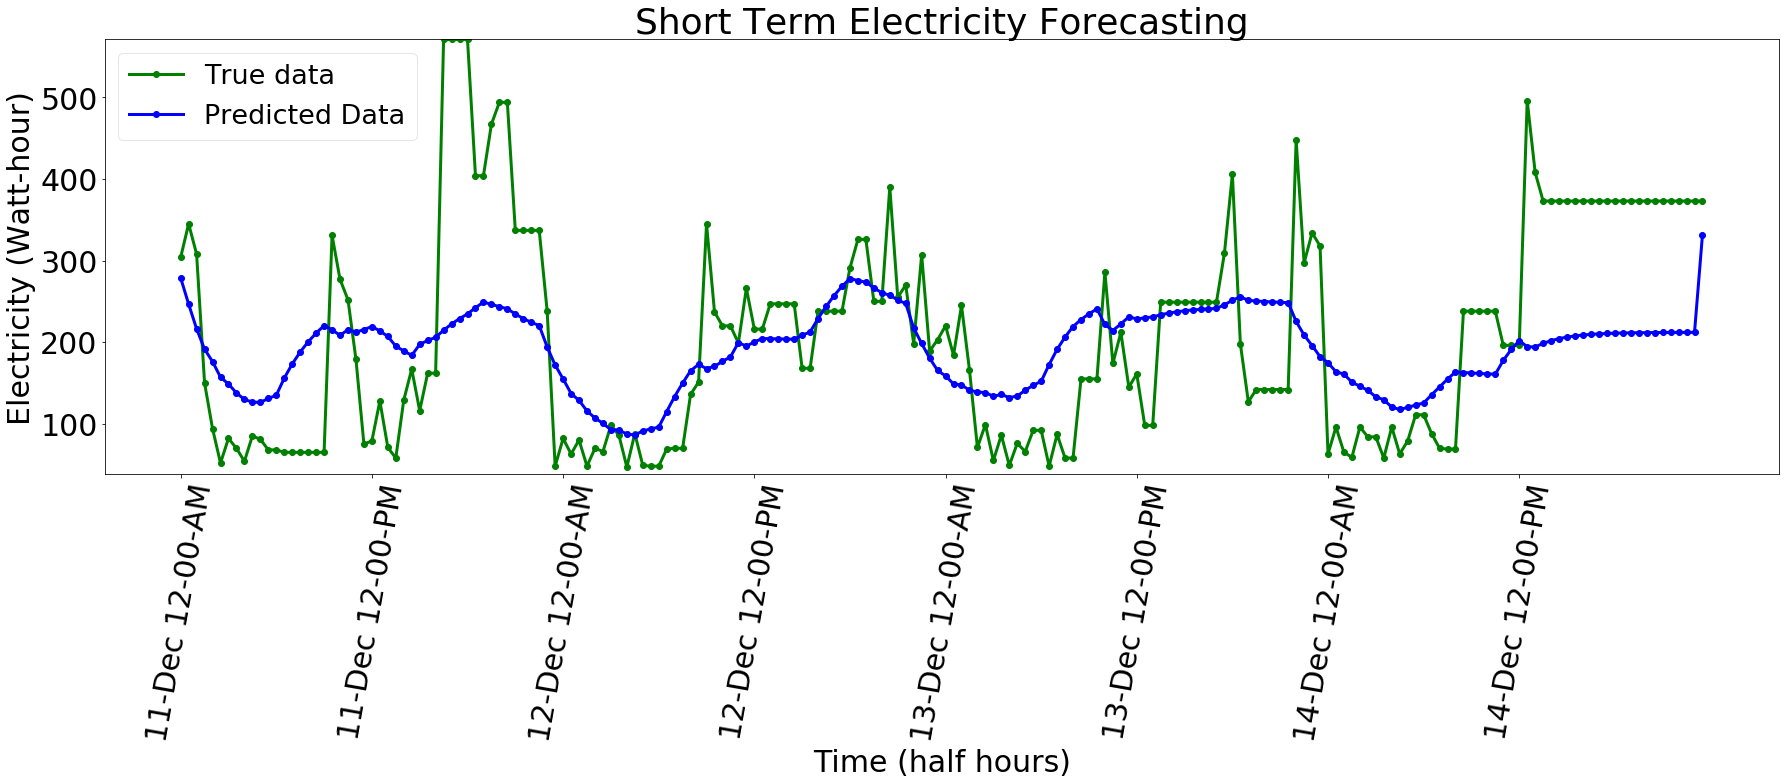

In [61]:
plt.figure(figsize=(30,8))
plt.rcParams.update({'font.size': 30})
plt.plot(test_y1_un_scaled,'go-', label='True data', linewidth=3)
plt.plot(np.roll(pred_list_un_scaled, -1),'bo-',label='Predicted Data', linewidth=3)
plt.ylabel('Electricity (Watt-hour)', fontsize=30)
plt.xlabel('Time (half hours)', fontsize=30)


x=np.arange(0,len(test_y1_un_scaled),24)
y=df.index.strftime('%d-%b %I-%M-%p')[original_n_train_time::24]
plt.xticks(x, y, rotation=80)

plt.ylim(ymin=x_min,ymax=x_max)
plt.title('Short Term Electricity Forecasting')
plt.legend(loc='upper left', fontsize=27,framealpha=0.5)
plt.savefig('LSTM_365.pdf', bbox_inches='tight')
# print ('NRMSE: ',(np.sqrt(mean_squared_error(test_y1_un_scaled, np.roll(pred_list_un_scaled, -1))))/np.mean(test_y1_un_scaled))
rmse=np.sqrt(mean_squared_error(test_y1_un_scaled, np.roll(pred_list_un_scaled, -1)))
print('RMSE: ', rmse)
print ('NRMSE: ',((rmse-x_min)/(x_max-x_min)))

RMSE:  136.2196920541038
NRMSE:  0.18427709578631105


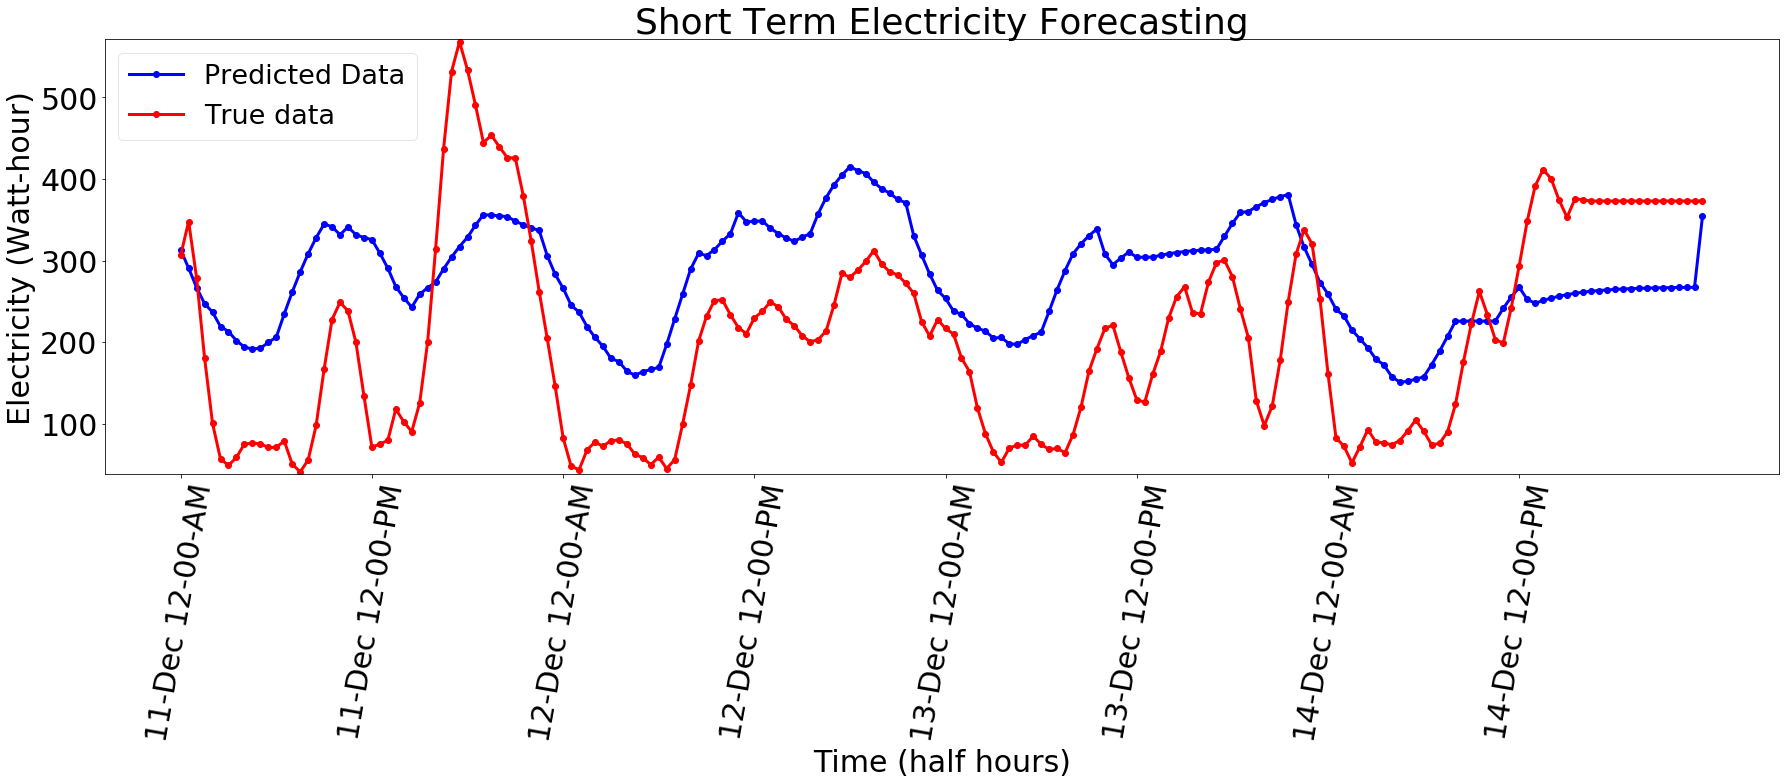

In [40]:
plt.figure(figsize=(30,8))
plt.rcParams.update({'font.size': 30})
# plt.plot(test_y1_un_scaled,'go-', label='True data', linewidth=3)
plt.plot(np.roll(pred_list_un_scaled, -1),'bo-',label='Predicted Data', linewidth=3)
plt.ylabel('Electricity (Watt-hour)', fontsize=30)
plt.xlabel('Time (half hours)', fontsize=30)

gamma=signal.savgol_filter(test_y1_un_scaled, 13, 5)
plt.plot(gamma,'ro-', label='True data', linewidth=3)

x=np.arange(0,len(test_y1_un_scaled),24)
y=df.index.strftime('%d-%b %I-%M-%p')[original_n_train_time::24]
plt.xticks(x, y, rotation=80)

plt.ylim(ymin=x_min,ymax=x_max)
plt.title('Short Term Electricity Forecasting')
plt.legend(loc='upper left', fontsize=27,framealpha=0.5)
plt.savefig('5a.pdf', bbox_inches='tight')
rmse=np.sqrt(mean_squared_error(test_y1_un_scaled, np.roll(pred_list_un_scaled, -1)))
print('RMSE: ', rmse)
print ('NRMSE: ',((rmse-x_min)/(x_max-x_min)))

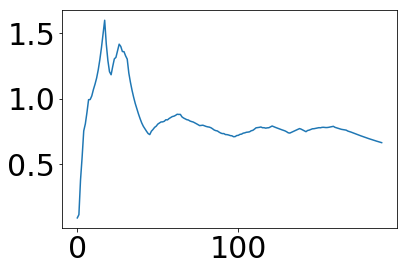

In [41]:
rmse=[];
for e in range(2,len(pred_list_un_scaled)):
    rmse.append((np.sqrt(mean_squared_error(test_y1_un_scaled[1:e], np.roll(pred_list_un_scaled[1:e], -1))))/np.mean(test_y1_un_scaled[1:e]))
#     print ('RMSE for ',e,' predictions: ',)
plt.plot(rmse)

In [42]:
train_y_un_scaled=train_y*(x_max-x_min)+x_min
pred_train_x_un_scaled=pred_train_x*(x_max-x_min)+x_min

NameError: name 'pred_train_x' is not defined

In [ ]:
# Training Data
pred_train_x = model.predict(train_X)
plt.figure(figsize=(20,5)) 
plt.plot(train_y_un_scaled[1:96])
# plt.plot(pred_train_x[1:96])
plt.plot(np.roll(pred_train_x_un_scaled[1:96], -1))
plt.legend(['True data', 'Predicted data'], loc='upper right')
plt.title('Training data prediction')
plt.xlabel('Time')
plt.ylabel('Electricity (Watt-hours)')
plt.show()
rmse_train=np.sqrt(mean_squared_error(train_y_un_scaled, np.roll(pred_train_x_un_scaled, -1)))
print('RMSE: ', rmse_train)
print ('NRMSE: ',((rmse_train-x_min)/(x_max-x_min)))

In [ ]:
model.get_weights()

In [ ]:
model.summary()

In [ ]:
model.get_config()

In [ ]:
model.to_json()

In [ ]:
model.to_yaml()